In [1]:
import warnings
warnings.filterwarnings("ignore")

#import snapatac2 as snap
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import bin.utils as myutils

In [2]:
sc.logging.print_header()

anndata	0.11.4
pandas	2.2.3
scanpy	1.11.1
numpy	2.2.5
matplotlib	3.10.1
----	----
leidenalg	0.10.2
igraph	0.11.8
pillow	11.2.1
llvmlite	0.44.0
pure_eval	0.2.3
decorator	5.2.1
traitlets	5.14.3
prompt_toolkit	3.0.51
threadpoolctl	3.6.0
Pygments	2.19.1
pyzmq	26.4.0
platformdirs	4.3.7
setuptools	79.0.1
PyYAML	6.0.2
session-info2	0.1.2
ipython	9.1.0
asttokens	3.0.0
pyparsing	3.2.3
packaging	25.0
six	1.17.0
wcwidth	0.2.13
charset-normalizer	3.4.1
jupyter_client	8.6.3
scipy	1.15.2
python-dateutil	2.9.0.post0
tornado	6.4.2
psutil	7.0.0
cycler	0.12.1
stack_data	0.6.3
defusedxml	0.7.1
joblib	1.4.2
h5py	3.13.0
scikit-learn	1.5.2
kiwisolver	1.4.8
pytz	2025.2
executing	2.1.0
Cython	3.0.12
comm	0.2.2
numba	0.61.2
jupyter_core	5.7.2
legacy-api-wrap	1.4.1
jedi	0.19.2
texttable	1.7.0
debugpy	1.8.14
natsort	8.4.0
ipykernel	6.29.5
parso	0.8.4
----	----
Python	3.13.3 | packaged by conda-forge | (main, Apr 14 2025, 20:44:03) [GCC 13.3.0]
OS	Linux-5.15.0-139-generic-x86_64-with-glibc2.35
CPU	256 logical CPU cores, x86_64
GPU	No GPU found
Updated	2025-05-07 19:28

In [3]:
os.getcwd()

'/nfs/cellgeni/pasham/projects/2504.ovary_atac/src/ovary'

In [4]:
# integration done using scvi/scanvi with dataset_donor as a batch (see 03.run.scanvi.sh)
data = sc.read_h5ad('../../data.lustre/atac/scanvi_out/combined_gene_matrix_plus_ref_scanvi.h5ad')
data.raw = sc.read_h5ad('../../data.lustre/atac/scanvi_out/combined_gene_matrix_plus_ref.h5ad')
data

AnnData object with n_obs × n_vars = 467577 × 5000
    obs: 'Donor', 'Age', 'coarse_annotation', 'Dataset', 'Developmental_stage', 'Sampling_site', 'Sampling_site_II', 'Sample', 'sample', 'dataset', 'dataset_donor', 'coarse_annotation_scanvi', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [5]:
data.raw.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1834214671 stored elements and shape (467577, 19446)>

In [6]:
# to use for knn annotation annoy is not working
sc.external.pp.bbknn(data,batch_key='dataset',use_annoy=False,neighbors_within_batch=50,use_rep='X_scANVI')

In [ ]:
sc.tl.leiden(data,resolution=0.5,key_added='leiden_0.5',flavor='igraph')
sc.tl.leiden(data,resolution=1,key_added='leiden_1',flavor='igraph')
sc.tl.leiden(data,resolution=2,key_added='leiden_2',flavor='igraph')
sc.tl.leiden(data,resolution=3,key_added='leiden_3',flavor='igraph')

# Check umap and predictions
C_scANVI - scanvi prediction based on coarse_annotation

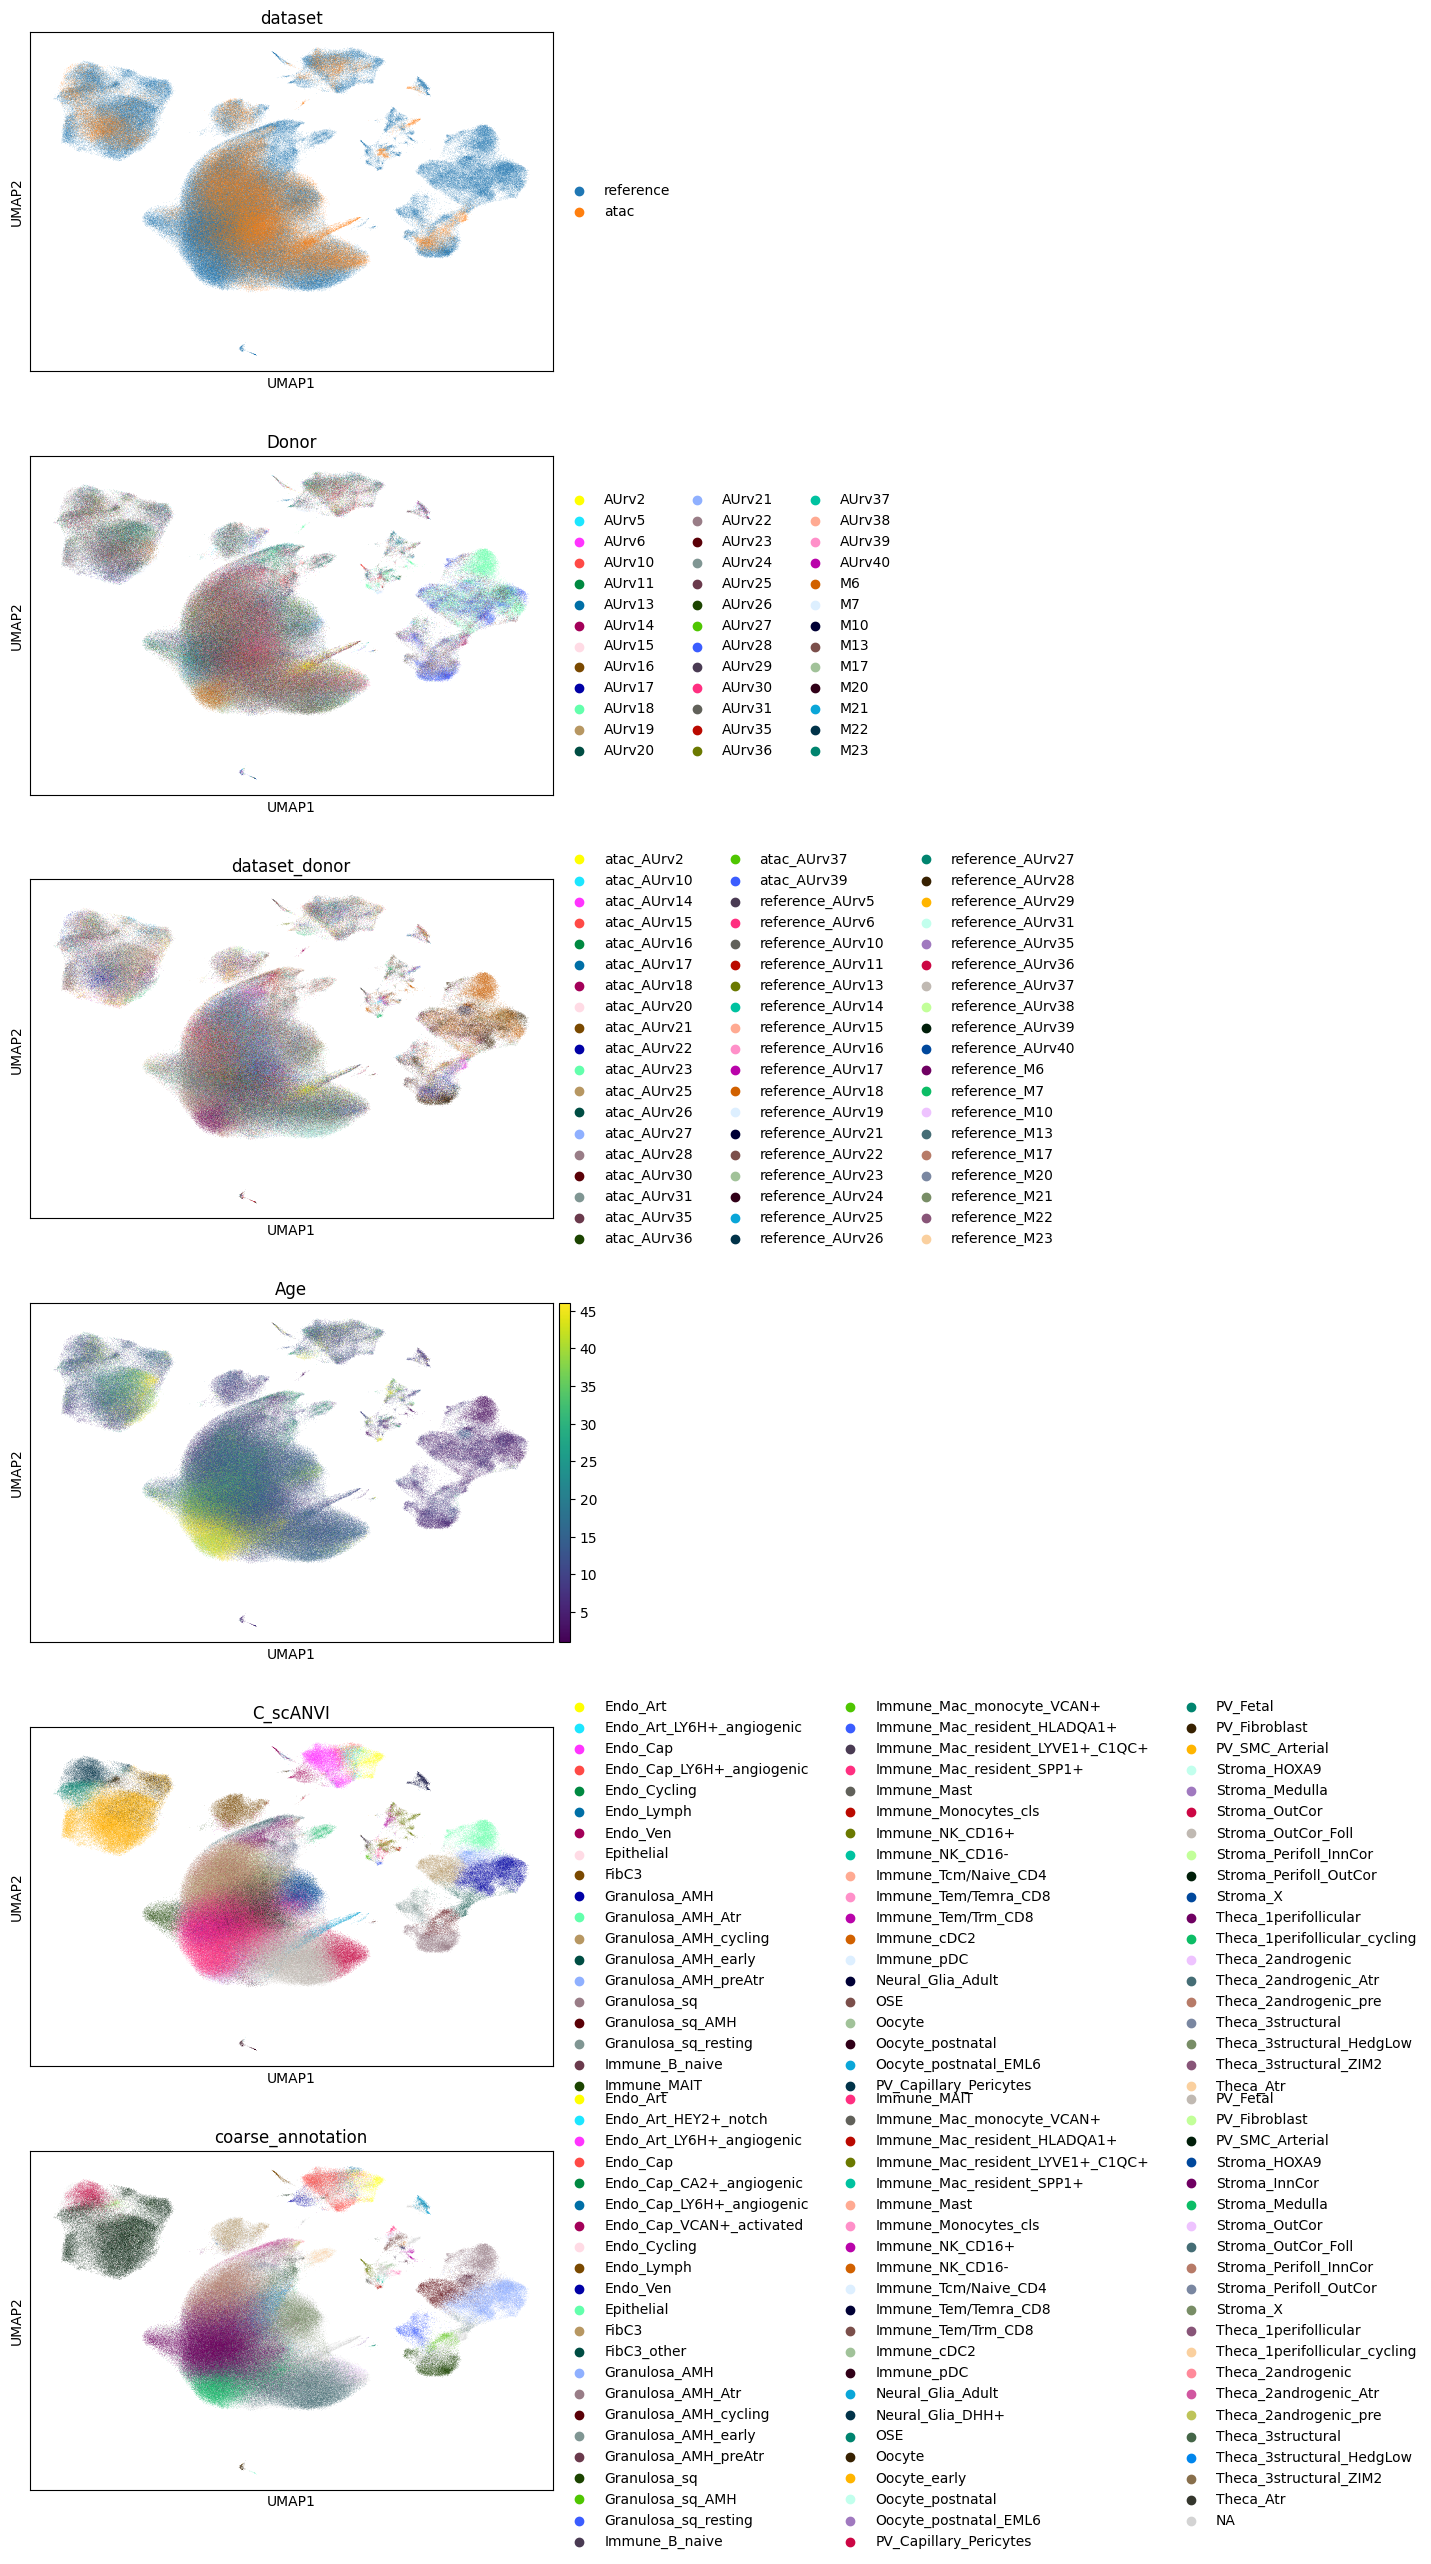

In [8]:
# prediction is in C_scANVI
sc.pl.umap(data,color=['dataset','Donor','dataset_donor','Age','C_scANVI','coarse_annotation'],ncols=1)

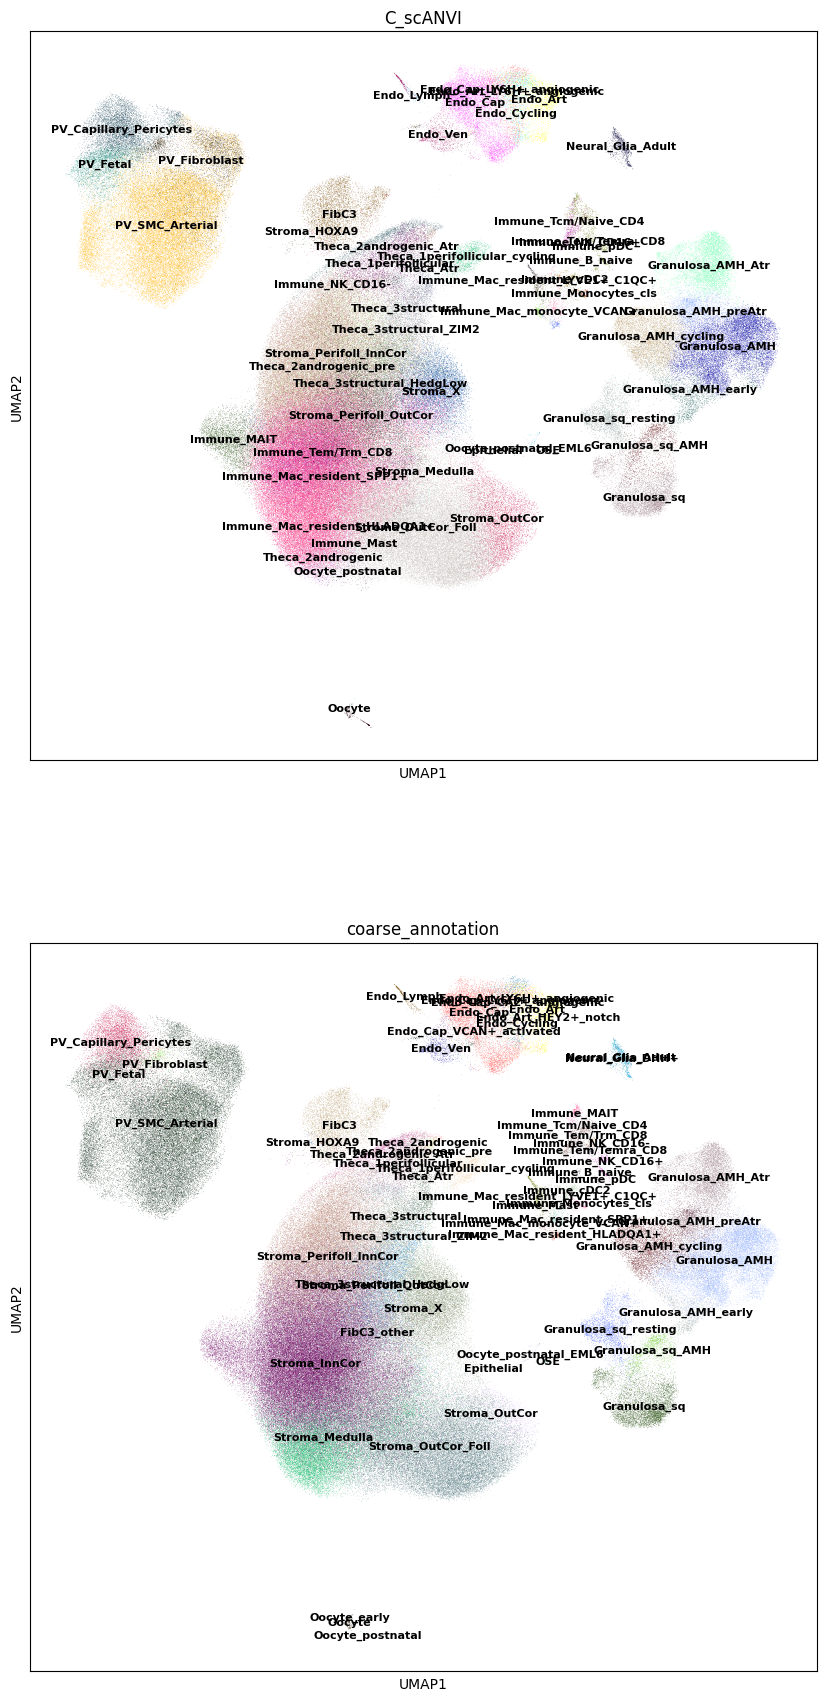

In [9]:
plt.rcParams['figure.figsize'] = [10, 10]
sc.pl.umap(data[data.obs.dataset=='reference',:],color=['C_scANVI','coarse_annotation'],ncols=1,legend_loc='on data', legend_fontsize=8)

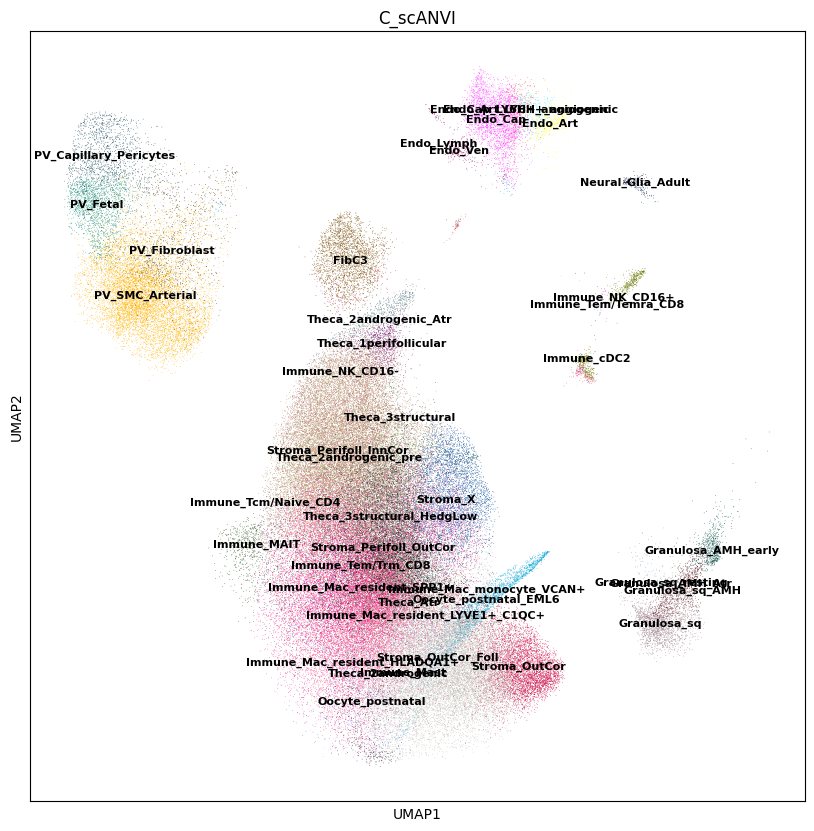

In [10]:
sc.pl.umap(data[data.obs.dataset=='atac',:],color=['C_scANVI'],ncols=1,legend_loc='on data', legend_fontsize=8)

# Check predictions in reference

In [11]:
pd.set_option('display.max_rows', 100)
f = data.obs.dataset=='reference'
t = pd.crosstab(data.obs.coarse_annotation[f],data.obs.coarse_annotation.astype(str)[f] == data.obs.C_scANVI[f])
t['f_lost'] = t[False]/(t[False]+t[True])
t = t.sort_values(by=[False],ascending=False)
t['major_prediction'] = ''
t['major_prediction_f'] = pd.NA
for c in t.index:
    cc = data.obs.C_scANVI[f & (data.obs.coarse_annotation==c)].value_counts()
    t.loc[c,'major_prediction'] = cc.index[0]
    t.loc[c,'major_prediction_f'] = cc[0]/cc.sum()
t.sort_values(False,ascending=False)

col_0                             False   True    f_lost  \
coarse_annotation                                          
Stroma_InnCor                     86895      0  1.000000   
Stroma_Perifoll_InnCor            26206   4611  0.850375   
Stroma_Medulla                    23706      1  0.999958   
Stroma_X                          15272   8637  0.638755   
PV_SMC_Arterial                    8746  31731  0.216073   
Stroma_OutCor_Foll                 7674  28297  0.213339   
Granulosa_AMH                      2875  13319  0.177535   
Theca_3structural_HedgLow          2241   3007  0.427020   
Stroma_Perifoll_OutCor             2171   2812  0.435681   
Endo_Cap                           1133   6441  0.149591   
FibC3                               918   5287  0.147945   
PV_Capillary_Pericytes              860   4750  0.153298   
Granulosa_AMH_preAtr                818   1855  0.306023   
Granulosa_AMH_cycling               778   4888  0.137310   
Stroma_OutCor                       766   2153  0.262419   
Theca_3structural                   583   2351  0.198705   
Granulosa_AMH_Atr                   520   6333  0.075879   
Immune_Tem/Trm_CD8                  514    390  0.568584   
Granulosa_sq                        485   5370  0.082835   
Endo_Art                            367   2065  0.150905   
Theca_Atr                           337     90  0.789227   
PV_Fibroblast                       305   1283  0.192065   
Immune_cDC2                         276    160  0.633028   
Immune_Tcm/Naive_CD4                260     15  0.945455   
Theca_1perifollicular               257   2390  0.097091   
Granulosa_sq_resting                251   2647  0.086611   
Immune_MAIT                         239     26  0.901887   
Endo_Lymph                          217    101  0.682390   
Theca_3structural_ZIM2              202     13  0.939535   
Immune_Mac_resident_LYVE1+_C1QC+    201    361  0.357651   
Theca_2androgenic_Atr               181   2225  0.075229   
Theca_2androgenic                   178     32  0.847619   
Immune_Monocytes_cls                169    134  0.557756   
Neural_Glia_DHH+                    167      0  1.000000   
PV_Fetal                            160    261  0.380048   
Oocyte                              157     30  0.839572   
Theca_1perifollicular_cycling       150   1316  0.102319   
Endo_Cap_LY6H+_angiogenic           122    897  0.119725   
Theca_2androgenic_pre               112    546  0.170213   
Immune_Tem/Temra_CD8                103     28  0.786260   
Immune_NK_CD16-                      88      1  0.988764   
Endo_Cycling                         70     55  0.560000   
Granulosa_sq_AMH                     68   1348  0.048023   
Immune_pDC                           64      3  0.955224   
Endo_Ven                             47    881  0.050647   
Immune_Mac_monocyte_VCAN+            44    132  0.250000   
Stroma_HOXA9                         44      1  0.977778   
Immune_Mac_resident_HLADQA1+         40    165  0.195122   
Immune_B_naive                       31      3  0.911765   
Epithelial                           29      1  0.966667   
Granulosa_AMH_early                  25   1063  0.022978   
Immune_Mac_resident_SPP1+            25    165  0.131579   
Endo_Art_LY6H+_angiogenic            17    223  0.070833   
Immune_Mast                          10      8  0.555556   
Endo_Cap_VCAN+_activated              8      0  1.000000   
Endo_Art_HEY2+_notch                  6      0  1.000000   
Oocyte_early                          6      0  1.000000   
FibC3_other                           5      0  1.000000   
Immune_NK_CD16+                       5    320  0.015385   
Endo_Cap_CA2+_angiogenic              2      0  1.000000   
Neural_Glia_Adult                     2    826  0.002415   
Oocyte_postnatal                      0    102  0.000000   
OSE                                   0     46  0.000000   
Oocyte_postnatal_EML6                 0     68  0.000000   

col_0                                  

scanvi annotation looks strange, it annotated  
**Stroma_InnCor** and **Stroma_Medulla** as **Immune_Mac_resident_SPP1+**   
**Stroma_Perifoll_InnCor** as **Theca_2androgenic_pre**  
So I'll use bbknn to annotate by neighbors

# Annotate ATAC

In [21]:
%%time
res = myutils.annotateByKnn(data,knn_key = 'distances',ann_key = 'coarse_annotation')
res

CPU times: user 2min 57s, sys: 2.63 s, total: 3min
Wall time: 2min 58s


coarse_annotation  \
HCA_P_GON_CZI12935964_AAACCTGAGACTGGGT-Sanger_p...  Endo_Cap_LY6H+_angiogenic   
HCA_P_GON_CZI12935964_AAACCTGCAAGTTGTC-Sanger_p...     PV_Capillary_Pericytes   
HCA_P_GON_CZI12935964_AAACCTGCAGACACTT-Sanger_p...            PV_SMC_Arterial   
HCA_P_GON_CZI12935964_AAACCTGCATTCACTT-Sanger_p...            PV_SMC_Arterial   
HCA_P_GON_CZI12935964_AAACCTGGTTACGCGC-Sanger_p...                      FibC3   
...                                                                       ...   
HCA_P_GON_CZI15033385:TTTGTGTGTACCTATG-1_atac                 PV_SMC_Arterial   
HCA_P_GON_CZI15033385:TTTGTGTTCAAGAGAT-1_atac              Stroma_OutCor_Foll   
HCA_P_GON_CZI15033385:TTTGTGTTCGCATACA-1_atac                        Endo_Ven   
HCA_P_GON_CZI15033385:TTTGTGTTCGCGCCAA-1_atac                   Stroma_InnCor   
HCA_P_GON_CZI15033385:TTTGTGTTCTACATCT-1_atac                  Stroma_Medulla   

                                                    major_cnt  total  \
HCA_P_GON_CZI12935964_AAACCTGAGACTGGGT-Sanger_p...         30     49   
HCA_P_GON_CZI12935964_AAACCTGCAAGTTGTC-Sanger_p...         45     49   
HCA_P_GON_CZI12935964_AAACCTGCAGACACTT-Sanger_p...         49     49   
HCA_P_GON_CZI12935964_AAACCTGCATTCACTT-Sanger_p...         49     49   
HCA_P_GON_CZI12935964_AAACCTGGTTACGCGC-Sanger_p...         49     49   
...                                                       ...    ...   
HCA_P_GON_CZI15033385:TTTGTGTGTACCTATG-1_atac              47     50   
HCA_P_GON_CZI15033385:TTTGTGTTCAAGAGAT-1_atac              46     50   
HCA_P_GON_CZI15033385:TTTGTGTTCGCATACA-1_atac              49     50   
HCA_P_GON_CZI15033385:TTTGTGTTCGCGCCAA-1_atac              39     50   
HCA_P_GON_CZI15033385:TTTGTGTTCTACATCT-1_atac              27     50   

                                                    confidence  
HCA_P_GON_CZI12935964_AAACCTGAGACTGGGT-Sanger_p...    0.612245  
HCA_P_GON_CZI12935964_AAACCTGCAAGTTGTC-Sanger_p...    0.918367  
HCA_P_GON_CZI12935964_AAACCTGCAGACACTT-Sanger_p...    1.000000  
HCA_P_GON_CZI12935964_AAACCTGCATTCACTT-Sanger_p...    1.000000  
HCA_P_GON_CZI12935964_AAACCTGGTTACGCGC-Sanger_p...    1.000000  
...                                                        ...  
HCA_P_GON_CZI15033385:TTTGTGTGTACCTATG-1_atac         0.940000  
HCA_P_GON_CZI15033385:TTTGTGTTCAAGAGAT-1_atac         0.920000  
HCA_P_GON_CZI15033385:TTTGTGTTCGCATACA-1_atac         0.980000  
HCA_P_GON_CZI15033385:TTTGTGTTCGCGCCAA-1_atac         0.780000  
HCA_P_GON_CZI15033385:TTTGTGTTCTACATCT-1_atac         0.540000  

[467577 rows x 4 columns]

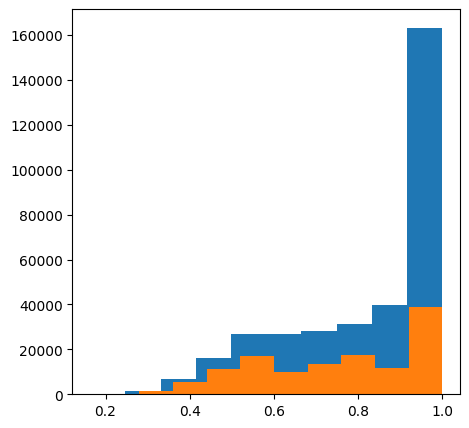

In [23]:
plt.rcParams['figure.figsize'] = [5, 5]
n=plt.hist(res.confidence[(data.obs.dataset=='reference').tolist()])
n=plt.hist(res.confidence[(data.obs.dataset=='atac').tolist()])

In [ ]:
# bbknn predicted annotation for atac and reference one for reference
data.obs['coarse_annotation_bbknn'] = res['coarse_annotation']
data.obs['coarse_annotation_bbknn'][data.obs.dataset=='reference'] = data.obs['coarse_annotation'][data.obs.dataset=='reference']
data.obs['coarse_annotation_bbknn_confidence'] = res['confidence']
data.obs['coarse_annotation_bbknn_confidence'][data.obs.dataset=='reference'] = 1
data.obs['coarse_annotation_bbknn'] = data.obs['coarse_annotation_bbknn'].astype('category')
data.obs['coarse_annotation'] = data.obs['coarse_annotation'].astype('category')

In [22]:
cmap = plt.get_cmap('nipy_spectral')
n = len(data.obs['coarse_annotation'].cat.categories)
colors = [mcolors.to_hex(cmap(i / n)) for i in range(n)]
#colors = dict(zip(data.obs['coarse_annotation'].cat.categories, colors))
data.uns['coarse_annotation_bbknn_colors'] = colors
data.uns['coarse_annotation_colors'] = colors

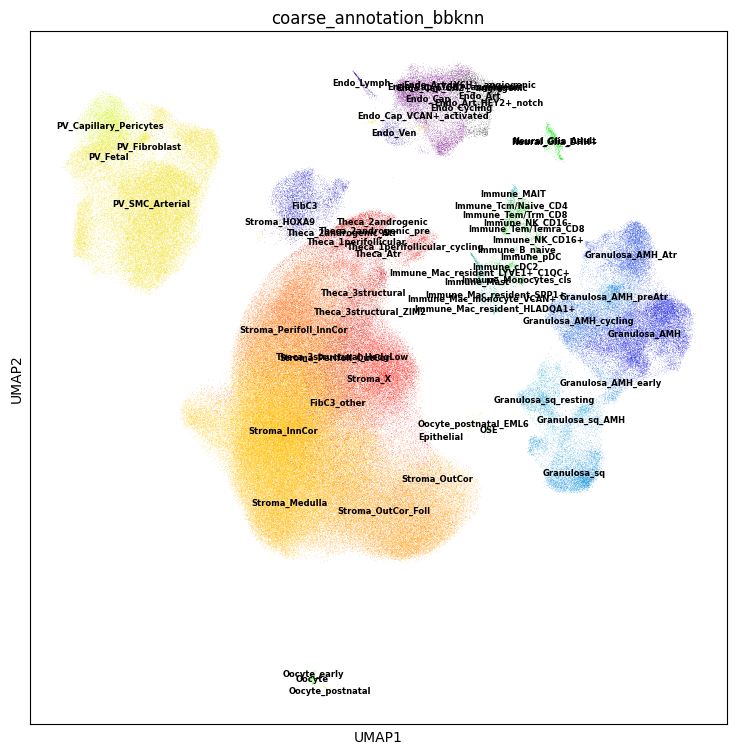

In [23]:
plt.rcParams['figure.figsize'] = [9, 9]
sc.pl.umap(data[data.obs.dataset=='reference'],color=['coarse_annotation_bbknn'],ncols=1,legend_loc='on data',legend_fontsize=6)

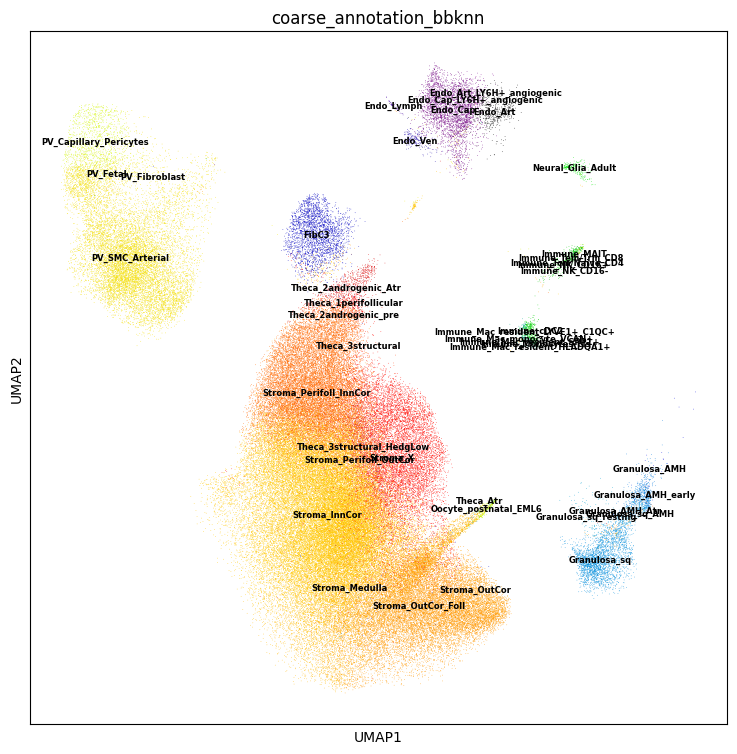

In [25]:
sc.pl.umap(data[data.obs.dataset=='atac'],color=['coarse_annotation_bbknn'],ncols=1,legend_loc='on data',legend_fontsize=6)

In [29]:
data.write_h5ad('../../data.lustre/atac/scanvi_out/combined_gene_matrix_plus_ref_scanvi_raw.h5ad')

# Cell type abundance in ref and atac

In [4]:
data = sc.read_h5ad('../../data.lustre/atac/scanvi_out/combined_gene_matrix_plus_ref_scanvi_raw.h5ad')

In [5]:
pd.set_option('display.max_rows', 1000)
ctcounts = pd.crosstab(data.obs.coarse_annotation_bbknn,data.obs.dataset)
ctcounts['atac_iodds'] = ctcounts.atac/ctcounts.atac.sum()/ctcounts.reference*ctcounts.reference.sum()
ctcounts['frac_diff'] = ctcounts.atac/ctcounts.atac.sum() - ctcounts.reference/ctcounts.reference.sum()
ctcounts['ncell_diff'] = (ctcounts['frac_diff']  * ctcounts.atac.sum()).round()
ctcounts = ctcounts.sort_values('ncell_diff',ascending=True)
ctcounts 

dataset                           reference   atac  atac_iodds  frac_diff  \
coarse_annotation_bbknn                                                     
Granulosa_AMH                         16194     29    0.004797  -0.047335   
PV_SMC_Arterial                       40477  11824    0.782483  -0.025860   
Granulosa_AMH_Atr                      6853     11    0.004300  -0.020041   
Granulosa_AMH_cycling                  5666      0    0.000000  -0.016642   
Stroma_Medulla                        23707   6896    0.779183  -0.015375   
Stroma_Perifoll_OutCor                 4983    465    0.249966  -0.010977   
Theca_3structural_HedgLow              5248    617    0.314927  -0.010560   
Theca_3structural                      2934      2    0.001826  -0.008602   
Granulosa_AMH_preAtr                   2673      0    0.000000  -0.007851   
PV_Capillary_Pericytes                 5610   1136    0.542418  -0.007540   
Granulosa_sq_resting                   2898    176    0.162680  -0.007127   
Theca_1perifollicular                  2647    323    0.326864  -0.005233   
Stroma_OutCor                          2919    541    0.496457  -0.004317   
Theca_1perifollicular_cycling          1466      0    0.000000  -0.004306   
Endo_Art                               2432    500    0.550713  -0.003209   
PV_Fibroblast                          1588    191    0.322182  -0.003161   
Theca_2androgenic_pre                   658      5    0.020355  -0.001893   
Endo_Cap_LY6H+_angiogenic              1019    143    0.375907  -0.001868   
Theca_2androgenic_Atr                  2406    665    0.740363  -0.001835   
Theca_Atr                               427      7    0.043913  -0.001199   
PV_Fetal                                421      8    0.050901  -0.001174   
Endo_Ven                                928    198    0.571526  -0.001168   
Granulosa_sq_AMH                       1416    382    0.722635  -0.001154   
Immune_NK_CD16+                         325      5    0.041210  -0.000915   
Neural_Glia_Adult                       828    205    0.663197  -0.000819   
Immune_Mac_resident_LYVE1+_C1QC+        562    113    0.538593  -0.000762   
Immune_MAIT                             265      5    0.050541  -0.000739   
Endo_Art_LY6H+_angiogenic               240      7    0.078128  -0.000650   
Immune_Monocytes_cls                    303     31    0.274055  -0.000646   
Theca_3structural_ZIM2                  215      0    0.000000  -0.000631   
Theca_2androgenic                       210      0    0.000000  -0.000617   
Endo_Lymph                              318     43    0.362210  -0.000596   
Immune_Mac_resident_HLADQA1+            205      5    0.065333  -0.000563   
Immune_Tcm/Naive_CD4                    275     32    0.311699  -0.000556   
Oocyte                                  187      0    0.000000  -0.000549   
Immune_Mac_monocyte_VCAN+               176      1    0.015220  -0.000509   
Neural_Glia_DHH+                        167      0    0.000000  -0.000490   
Immune_Tem/Temra_CD8                    131      0    0.000000  -0.000385   
Endo_Cycling                            125      0    0.000000  -0.000367   
Oocyte_postnatal                        102      0    0.000000  -0.000300   
Immune_NK_CD16-                          89      1    0.030097  -0.000254   
Immune_pDC                               67      0    0.000000  -0.000197   
Stroma_HOXA9                             45      0    0.000000  -0.000132   
OSE                                      46      0    0.000000  -0.000135   
Immune_B_naive                           34      0    0.000000  -0.000100   
Epithelial                               30      0    0.000000  -0.000088   
Immune_Mast                              18      0    0.000000  -0.000053   
Endo_Cap_VCAN+_activated                  8      0    0.000000  -0.000023   
Oocyte_early                              6      0    0.000000  -0.000018   
Endo_Art_HEY2+_notch                      6      0    0.000000  -0.000018

In [6]:
ctcounts[ctcounts.index.str.startswith('Granulosa')]

dataset                  reference  atac  atac_iodds  frac_diff  ncell_diff
coarse_annotation_bbknn                                                    
Granulosa_AMH                16194    29    0.004797  -0.047335     -6017.0
Granulosa_AMH_Atr             6853    11    0.004300  -0.020041     -2547.0
Granulosa_AMH_cycling         5666     0    0.000000  -0.016642     -2115.0
Granulosa_AMH_preAtr          2673     0    0.000000  -0.007851      -998.0
Granulosa_sq_resting          2898   176    0.162680  -0.007127      -906.0
Granulosa_sq_AMH              1416   382    0.722635  -0.001154      -147.0
Granulosa_AMH_early           1088   513    1.263011   0.000840       107.0
Granulosa_sq                  5855  2565    1.173490   0.002983       379.0

In [7]:
ctcounts.to_csv('celltype_counts.csv')

# Subset to Granulosa

In [40]:
gdata = data[data.obs.coarse_annotation_bbknn.str.startswith('Granulosa'),:].copy()
gdata = gdata.raw.to_adata()
sc.pp.normalize_total(gdata)
sc.pp.log1p(gdata)
gdata

AnnData object with n_obs × n_vars = 46319 × 19446
    obs: 'Donor', 'Age', 'coarse_annotation', 'Dataset', 'Developmental_stage', 'Sampling_site', 'Sampling_site_II', 'Sample', 'sample', 'dataset', 'dataset_donor', 'coarse_annotation_scanvi', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'coarse_annotation_bbknn', 'coarse_annotation_bbknn_confidence'
    uns: 'C_scANVI_colors', 'Donor_colors', '_scvi_manager_uuid', '_scvi_uuid', 'coarse_annotation_bbknn_colors', 'coarse_annotation_colors', 'dataset_colors', 'dataset_donor_colors', 'hvg', 'leiden_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'neighbors', 'umap', 'log1p'
    obsm: 'X_scANVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [45]:
del gdata.uns['coarse_annotation_bbknn_colors']

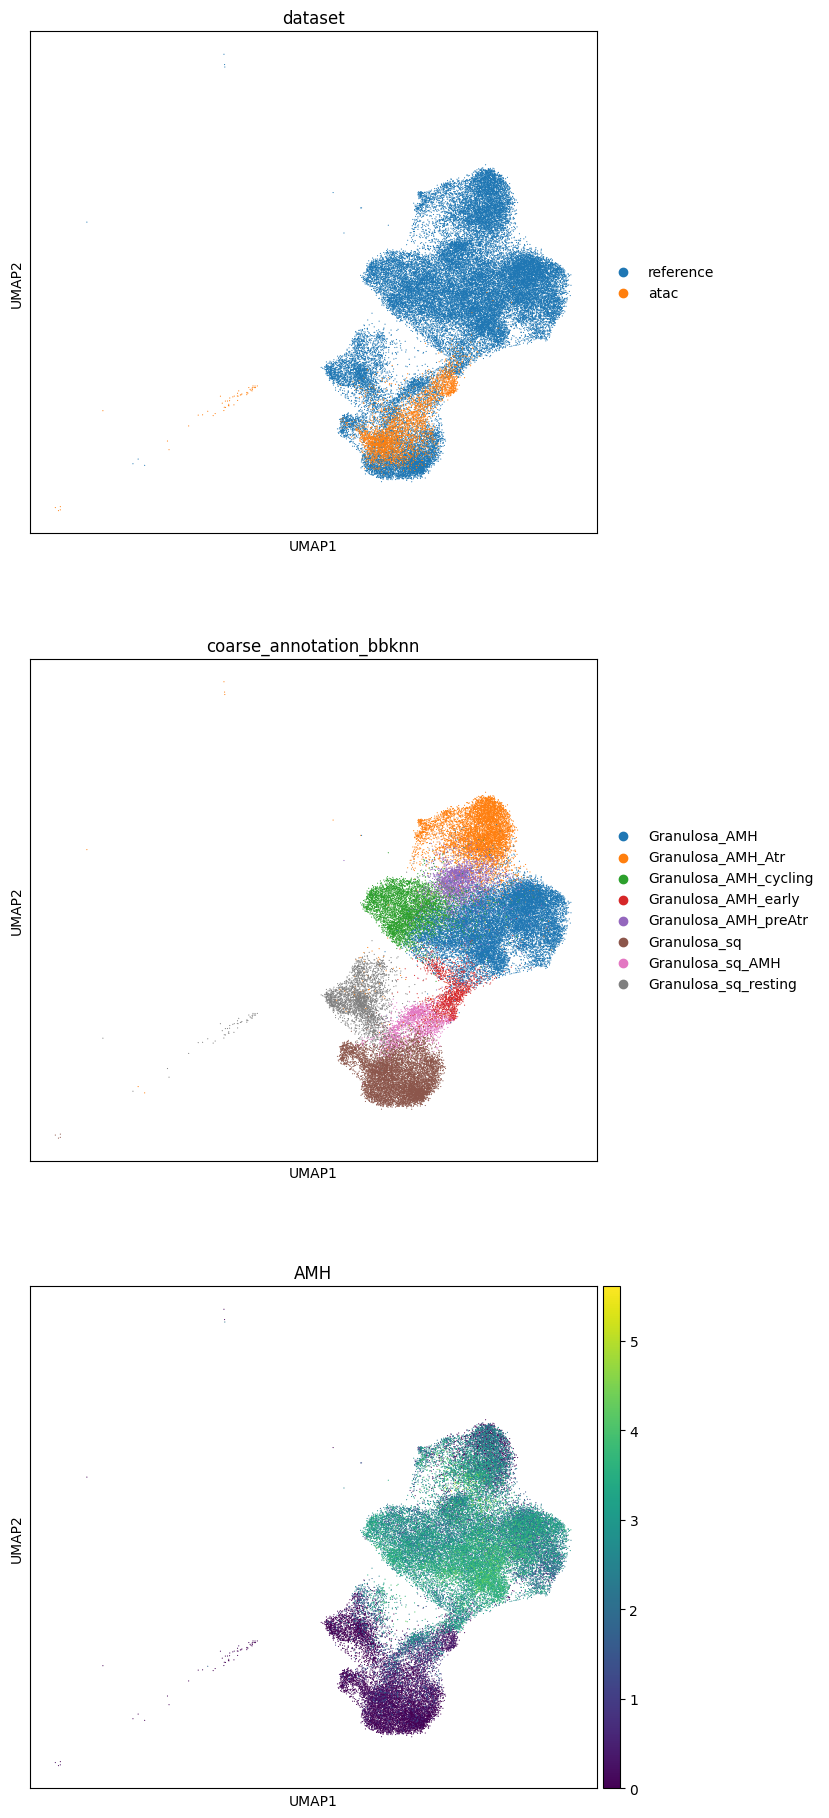

In [46]:
plt.rcParams['figure.figsize'] = [7, 7]

sc.pl.umap(gdata,color=['dataset','coarse_annotation_bbknn','AMH'],ncols=1)

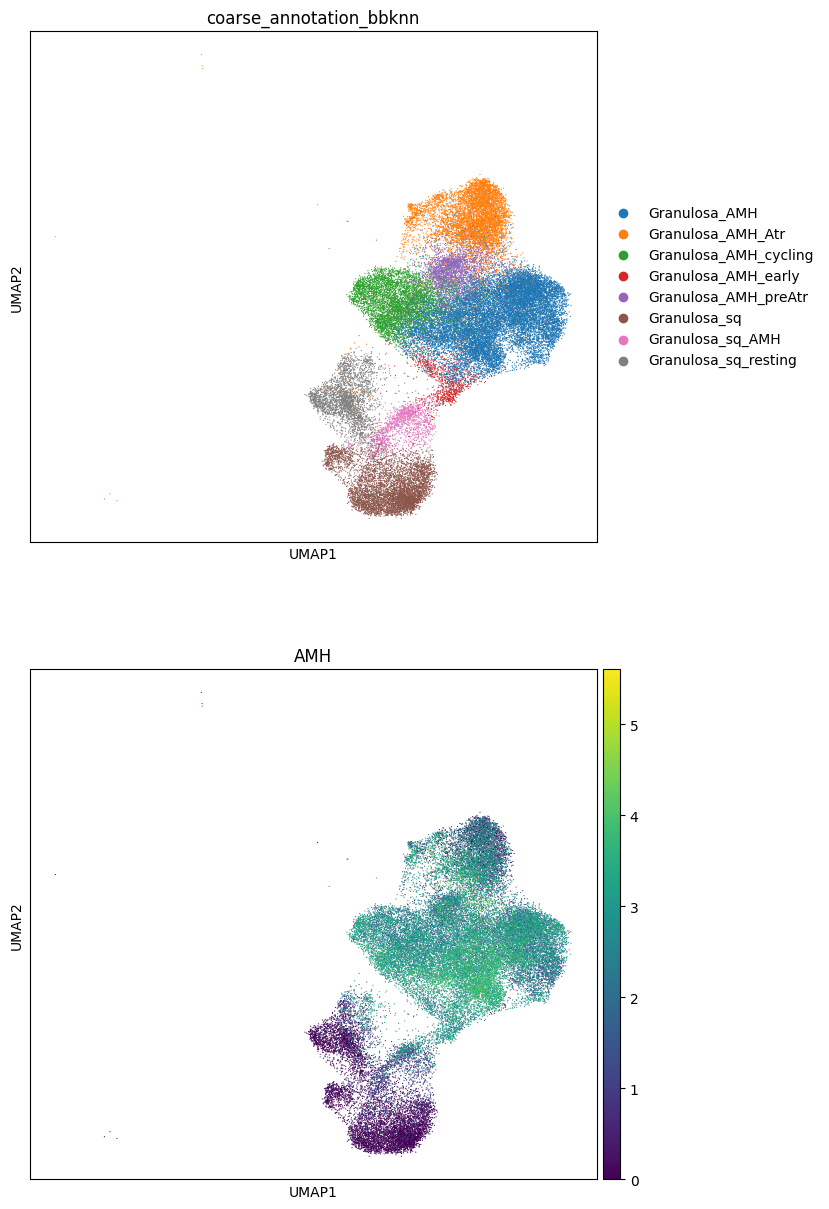

In [47]:
sc.pl.umap(gdata[gdata.obs.dataset=='reference'],color=['coarse_annotation_bbknn','AMH'],ncols=1,use_raw=False)

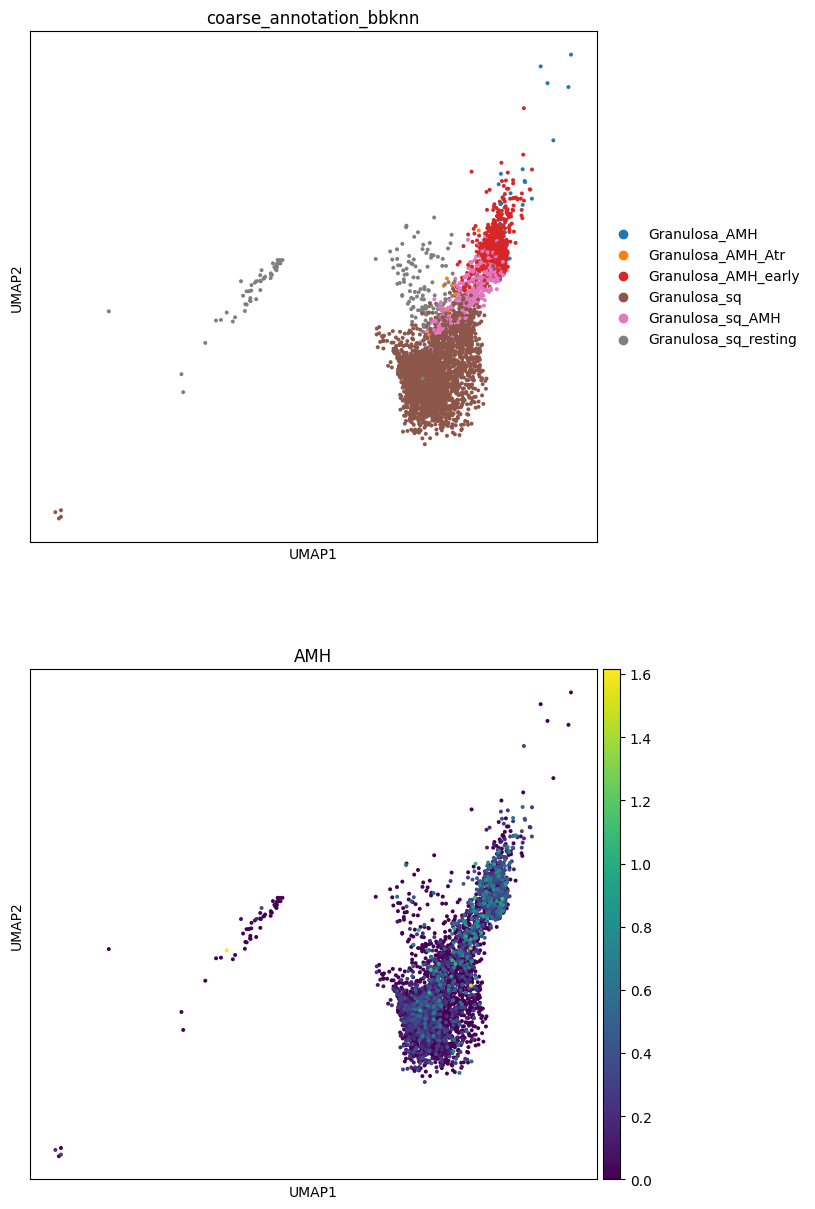

In [48]:
sc.pl.umap(gdata[gdata.obs.dataset=='atac'],color=['coarse_annotation_bbknn','AMH'],ncols=1,use_raw=False)